In [39]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
import random
import math
import time 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from indicnlp.tokenize import indic_tokenize
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [40]:
!pip install indic-nlp-library

You should consider upgrading via the '/Users/viksitpansari/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [41]:
# from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

# input_text="हाँ, हाँ, बिल्कुल. मैं उसे विफल रहा है, जीवन में।\n"
# remove_nuktas=False
# factory=IndicNormalizerFactory()
# normalizer=factory.get_normalizer("hi", remove_nuktas=True)
# output_text=normalizer.normalize(input_text)

# print(input_text)
# print()
# print(output_text)

# print('Before normalization')
# print(' '.join([ hex(ord(c)) for c in input_text ] ))
# print('Length: {}'.format(len(input_text)))
# print()    
# print('After normalization')
# print(' '.join([ hex(ord(c)) for c in output_text ] ))
# print('Length: {}'.format(len(output_text))) 

# from indicnlp.tokenize import indic_tokenize  

# indic_string='सुनो, कुछ आवाज़ आ रही है। फोन?'

# print('Input String: {}'.format(indic_string))
# print('Tokens: ')
# for t in hindi_tokenizer(indic_string): 
#     print(t)

In [44]:
df = pd.read_csv('./train_final.txt', delimiter = "\t", header = None)
df.rename(columns = {0 : 'hindi', 1 : 'english'}, inplace = True)
# df=df.reindex(columns=["english","hindi"])
en_tokenizer = spacy.load('en_core_web_sm')
df

,hindi,english
0,Batman2 vs2 Superman2,batman2 vs2 superman2
1,"The2 director2 is2 Zack2 Snyder2 , 27% Rotten2...","Zack2 Snyder2 director2 hai1 , 27% Rotten2 Tom..."
2,Not2 very2 popular2 it2 seems2,lagta1 hai1 bahut1 popular1 nahi1 hai1
3,But2 the2 audiences2 liked2 it2 . It2 has2 a1 ...,"but2 audience2 ne2 like1 kiya1 , iska1 cinema2..."
4,Yes1,yes1
...,...,...
8055,Ok1 .,Thik1 hai1
8056,ok1 bro1,Thik1 hai1 bhai1
8057,shall2 we2 continue2 ?,Kya1 ham1 chalu1 kar1 sakte1 hai1 ?
8058,do1 you2 like2 we2 can2,Kya1 aapko1 pasand1 hai1 hamare1 saath1


In [45]:

# train_temp, test_data_sent = train_test_split(df, test_size = 0.2)
# train_data_sent, validation_data_sent = train_test_split(train_temp, test_size=0.125)
# train_data_sent
# df=df.iloc[:10]
train_data_sent, test_data_sent = train_test_split(df, test_size = 0.2)
validation_data_sent = pd.read_csv('./dev_final.txt', delimiter = "\t", header = None)
validation_data_sent.rename(columns = {0 : 'hindi', 1 : 'english'}, inplace = True)
# train_data_sent
# validation_data_sent=validation_data_sent.iloc[:5]
validation_data_sent

,hindi,english
0,hello1,hello1
1,"hello1 there2 , I2 have2 not2 seen2 this2 movi...","hello1 yar1 , mein1 is2 movie1 ko1 nahi1 dekha..."
2,Alright2 that2 is2 fine2 . What2 is2 the2 movi...,acha1 tho1 is2 movie1 kis1 baare1 me1 hein1 ?
3,The2 movie2 is2 The2 Social2 Network2,is2 movie2 tho2 social2 network2 ke1 bare1 mei...
4,I2 have2 not2 seen2 that2 one2 either2 .,mein1 aise1 kuch1 nahi1 dekha1 hoon1
...,...,...
937,Yep2 . Thanks2 for2 chatting2,Yep2 . Thanks1 baat1 karne1 ke1 liye1
938,"thanks2 , I2 will2 watch2 it2 . SOunds1 good2","Thanks2 , mei1 dekhati1 hui1 . Achi1 baat1 hai1"
939,Hi1 !,Hi1 !
940,Did1 you2 like2 the2 movie2 Despicable2 Me2 ?,kya1 tumhe1 movie2 Despicable2 Me1 pasand1 hai...


In [46]:
train_data_sent.to_json('train_data.json', orient='records', lines=True)
validation_data_sent.to_json('validation_data.json', orient='records', lines=True)
test_data_sent.to_json('test_data.json', orient='records', lines=True)

In [47]:
def hindi_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]    
#     return [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [48]:
def english_tokenizer(sentence):
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())]

In [49]:
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>' , lower = True)
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [50]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

print(len(train_data), len(validation_data), len(test_data))

6448 942 1612


In [51]:
# print(train_data_sent)
print(vars(train_data.examples[0]))

{'english': ['kya1', 've1', 'paatr1', 'hain1', 'jo1', 'pyaar1', 'mein1', 'pad1', 'jaate1', 'hain1', '?'], 'hindi': ['are1', 'they2', 'the2', 'characters2', 'that2', 'fall2', 'in2', 'love2', '?']}


In [52]:
# for i in range(1,200,2):
#     ENGLISH.build_vocab(train_data, min_freq=i)
#     HINDI.build_vocab(train_data, min_freq=i)
#     print("\t",end=' ')
#     print(i,end=' - ')
#     print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")
    
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)
print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 4570, Hindi: 3502


In [53]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(input_size, embedding_size) 
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, input):
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be sentence_length x batch_size x embedding_size
        o, (h, c) = self.lstm(embeddings) # output shape will be sentence_length x batch_size x hidden size, hidden shape will be 1 x batch_size x hidden_size because we are returning only the final hidden layer

        return h, c

In [54]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size)
        self.linear = nn.Linear(embedding_size + hidden_size + hidden_size, output_size)
        self.output_size = output_size
        self.hidden_size = hidden_size

    def forward(self, input, h, c, z):        
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be 1 x batch_size x embedding_size
        o, (h, c) = self.lstm(torch.cat((embeddings, z), dim = 2), (h, c)) # shape will be 1 x batch_size x hidden_size
        predictions = self.linear(torch.cat((embeddings, h, z), dim = 2).squeeze(0)) # both shapes will be batch_size x output_vocabulary_size

        return predictions, h, c

In [55]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
         
    def forward(self, input, actual):
        
        h, c = self.encoder(input)
        z = h
        input = actual[0, :]
        predictions = torch.zeros(actual.shape[0], actual.shape[1], self.decoder.output_size).to(self.device)

        for t in range(1, actual.shape[0]):
            o, h, c = self.decoder(input.unsqueeze(0), h, c, z)
            predictions[t] = o
            predicted = o.argmax(1) 
            input = predicted

        return predictions

In [56]:
# a = 4
# b = a
# a = 6
# a += 1
# print(a, b)

In [57]:
def train(model, train_data_iterator, optimizer, criterion):
    
    model.train()    
    total_loss = 0
    
    for batch in train_data_iterator:
        input = batch.english
        actual = batch.hindi
        optimizer.zero_grad()
        predictions = model(input, actual)
        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
        loss = criterion(predictions, actual)
        loss.backward()   
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    average_loss = total_loss / len(train_data_iterator)
    return average_loss

In [58]:
def evaluate(model, data_iterator, criterion):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            actual = batch.hindi
            predictions = model(input, actual)
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
            loss = criterion(predictions, actual)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_iterator)
    return average_loss

In [59]:
enc = Encoder(len(ENGLISH.vocab), 350, 512, 0.5)
dec = Decoder(len(HINDI.vocab), 350, 512, 0.5)

model = Model(enc, dec, device).to(device)
for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)
model

Model(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(4570, 350)
    (lstm): LSTM(350, 512)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(3502, 350)
    (lstm): LSTM(862, 512)
    (linear): Linear(in_features=1374, out_features=3502, bias=True)
  )
)

In [60]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [61]:
best_loss = 1e9

train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

training_losses = []
validation_losses = []

for epoch in range(25):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'encoder_decoder.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f"Train Loss (exponent to analyse better): {np.exp(train_loss):.3f}")
    print(f"Val. Loss (exponent to analyse better): {np.exp(valid_loss):.3f}")

Epoch: 01
	Train Loss: 5.949 | Train PPL: 383.250
	 Val. Loss: 5.500 |  Val. PPL: 244.707
Train Loss (exponent to analyse better): 383.250
Val. Loss (exponent to analyse better): 244.707
Epoch: 02
	Train Loss: 5.710 | Train PPL: 301.888
	 Val. Loss: 5.460 |  Val. PPL: 235.042
Train Loss (exponent to analyse better): 301.888
Val. Loss (exponent to analyse better): 235.042
Epoch: 03
	Train Loss: 5.633 | Train PPL: 279.565
	 Val. Loss: 5.412 |  Val. PPL: 223.999
Train Loss (exponent to analyse better): 279.565
Val. Loss (exponent to analyse better): 223.999
Epoch: 04
	Train Loss: 5.549 | Train PPL: 256.963
	 Val. Loss: 5.387 |  Val. PPL: 218.529
Train Loss (exponent to analyse better): 256.963
Val. Loss (exponent to analyse better): 218.529
Epoch: 05
	Train Loss: 5.449 | Train PPL: 232.524
	 Val. Loss: 5.331 |  Val. PPL: 206.601
Train Loss (exponent to analyse better): 232.524
Val. Loss (exponent to analyse better): 206.601
Epoch: 06
	Train Loss: 5.365 | Train PPL: 213.716
	 Val. Loss: 5.

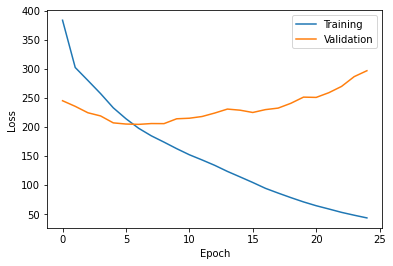

In [62]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
# def get_tranlsation(text):
#   model.eval()
#   with torch.no_grad():
#     tokens = [token.text.lower() for token in en_tokenizer.tokenizer(text)][::-1]
#     tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
#     src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
#     src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
#     src_tensor = src_tensor.reshape(-1,1)
#     output = model(src_tensor, src_tensor)
#     output_dim = output.shape[-1]
#     output = output.view(-1, output_dim)
#     indices = torch.argmax(output,dim=1).tolist()
#     return [HINDI.vocab.itos[x] for x in indices]

# print(get_tranlsation("How do you do it?"))

In [64]:
model.load_state_dict(torch.load('encoder_decoder.pt'))
test_loss = evaluate(model, test_data_iterator, criterion)
print(f"Test Loss (exponent to analyse better): {np.exp(test_loss):.3f}")

Test Loss (exponent to analyse better): 198.338


In [65]:
# vars(test_data.examples[2])

In [66]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['<unk>', 'i2', ',', '.', '<eos>', '<eos>', '<eos>']


In [67]:
import csv

translated_sentences = open('Paper1.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

translated_sentences.close()



In [68]:
with open('Paper1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} \t \t {row[1]} \t \t {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Input, Predicted, Actual
	Cool1 ! khoun1 sa1 character2 tha2 ? 	 	 what2 , a2 the2 	 	 Cool2 ! Which2 character2 is2 it2 ?.
	well2 to2 tum1 iske1 liye1 in1 ho1 , ye1 ek1 best2 seller2 par2 based2 he2 	 	 it2 , is2 the2 , <unk> , . the2 . <unk> . 	 	 well2 you're2 in2 for2 it2 , this2 ones2 based2 on2 a2 best2 seller2.
	Fairly2 old2 	 	 i2 . 	 	 Fairly2 old2.
	kya1 soundtrack2 tumhara1 favorite2 part2 tha1 ? 	 	 what2 , a2 the2 of2 	 	 Was2 the2 soundtrack2 your2 favorite2 part2 ?.
	bahut1 cool1 lagata1 hai1 	 	 i2 , . 	 	 that2 sounds2 cool2.
	Mujhe1 wo1 part1 yaad1 hau1 . Main1 movie1 ki1 ending2 enjoy2 ki2 . 	 	 i2 , , it2 the2 , . . . . . . 	 	 I2 do2 remember2 that2 part2 . I2 enjoyed2 the2 ending2 of2 the2 movie2 ..
	Usne1 duniya1 ka1 sabse1 bada1 social2 network2 banaya1 but1 wo1 ek1 aisa1 aadmi1 lagta1 hai1 jise1 log1 hate1 karte1 hai1 	 	 i2 , it2 the2 the2 , , , , , the2 the2 . . . . . . . . . 	 	 He2 founded2 the2 biggest2 social2 network2 the2 world2 has2 ev

In [1]:
# import csv

# translated_sentences = open('Paper2.csv','w')
# csvwriter = csv.writer(translated_sentences)
# csvwriter.writerow(['Input','Predicted','Actual'])  

import nltk

bleu_i = []
bleu_o = []

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  # csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  bleu_i.append(hin_sentence.strip())
  bleu_o.append(hindi_predicted.strip())

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

# translated_sentences.close()

BLEU_scores = []

for i in range(len(bleu_i)):
  BLEU_scores.append(nltk.translate.bleu_score.sentence_bleu(bleu_i[i], bleu_o[i], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7))
  
print("Average BLEU Score:", np.mean(BLEU_scores))



Average BLEU Score: 0.0718309294243317
